In [1]:
import os
from dotenv import load_dotenv
load_dotenv()  # loads the .env file
import openai
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment
from scipy.sparse import csr_matrix, hstack
import networkx as nx
import matplotlib.pyplot as plt

In [14]:
# config
openai.api_key = os.getenv("OPENAI_API_KEY")
MENTEES_CSV = 'steming mentorship/current/f25_mentees.csv'
MENTORS_CSV = 'steming mentorship/current/f25_mentors.csv'

In [15]:
# load data
mentees = pd.read_csv(MENTEES_CSV)
mentors = pd.read_csv(MENTORS_CSV)

In [16]:
# feature columns
mentee_mc_cols = [
    'Current year of high school',
    'Career of Interest',
    'What timezone are you in?',
    'Are you located in the GTA?',
    'First field 🥇',
    'Second field 🥈', 
    'Third field 🥉',
    'Select skills you are currently seeking to develop and work towards with a mentor for this term.',
    'How would you describe yourself in social situations?',
    'How often would you like to meet and chat with your mentor? 🗓'
]
mentee_txt_cols = [
    'What do you enjoy doing outside of school and work? 🎾🎮⛸️🪡🤿',
    'What do you hope to learn or gain from the mentorship program?'
]

mentor_mc_cols = [
    'Current profession/ role',
    'What did you study/ are you studying?',
    'What timezone are you in?',
    'Are you located in the GTA?',
    'First field 🥇',
    'Second field 🥈', 
    'Third field 🥉',
    'Do you have relevant experience or advice you would like to share with mentees on any of the following topics?',
    'How would you describe yourself in social situations?',
    'How often would you like to meet and chat with your mentee? 🗓'
]
mentor_txt_cols = [
    'What do you enjoy doing outside of school and work? 🎾🎮⛸️🪡🤿',
    'Why do you want to be a mentor? What are you looking to give and gain from this experience? We know balancing work, school, and life can be difficult. What will you do to help your mentee succeed and make them feel confident?',
    "Is there anything else you'd like us to know when considering you as a mentor or matching you with mentees?"
]

mentor_capacity_col = 'How many mentees would you like to mentor this term?'

In [17]:
# subset 
df_mtees = mentees[["Username", "First Name (Preferred)"] + mentee_mc_cols + mentee_txt_cols].copy()
df_mtors = mentors [ ["Username", "First Name"] + mentor_mc_cols + mentor_txt_cols + [mentor_capacity_col] ].copy()

In [18]:
# encode mc cols
# yes/no - 1/0
for df in (df_mtees, df_mtors):
    for col in ['Are you in Waterloo?']:
        df[col] = df[col].astype(str).str.lower().map({"yes": 1, "no": 0})
# timezone and categories - one-hot
X_mc = pd.get_dummies(df_mtees[mentee_mc_cols].astype(str), prefix_sep="|") # mentees
Y_mc = pd.get_dummies(df_mtors[mentor_mc_cols].astype(str), prefix_sep="|") # mentors
X_mc, Y_mc = X_mc.align(Y_mc, join="outer", axis=1, fill_value=0)

X_mc = X_mc.astype(float)
Y_mc = Y_mc.astype(float)

In [19]:
# tf-idf text
df_mtees["txt"] = df_mtees[mentee_txt_cols].fillna("").agg(" ".join, axis=1)
df_mtors["txt"] = df_mtors[mentor_txt_cols].fillna("").agg(" ".join, axis=1)

tfidf = TfidfVectorizer(max_features=2000)
tfidf.fit(pd.concat([df_mtees["txt"], df_mtors["txt"]]))
X_txt = tfidf.transform(df_mtees["txt"]) # mentees
Y_txt = tfidf.transform(df_mtors["txt"]) # mentors

In [20]:
# combine all features
X_mc_sparse = csr_matrix(X_mc.values)
Y_mc_sparse = csr_matrix(Y_mc.values)

X = hstack([X_mc_sparse, X_txt])
Y = hstack([Y_mc_sparse, Y_txt])

In [21]:
mentor_caps = df_mtors[mentor_capacity_col].astype(int).values 
slot2mentor = np.repeat(np.arange(len(mentor_caps)), mentor_caps) 
Y_slots = Y[slot2mentor] if isinstance(Y, csr_matrix) else csr_matrix(Y.toarray()[slot2mentor])

In [22]:
# compute cosine similarity and pick top 2 mentors
sim = cosine_similarity(X, Y_slots)

# build cost matrix for Hungarian: slots as rows, mentees as cols
cost = 1 - sim.T  # shape (num_slots, num_mentees)

# 1 mentor-slot -> 1 mentee for as many slots as possible
slot_idx, mentee_idx = linear_sum_assignment(cost)

In [23]:
# collect pairs
pairs = []
for slot, mentee in zip(slot_idx, mentee_idx):
    mentor = slot2mentor[slot]
    score  = sim[mentee, slot]
    pairs.append((mentee, mentor, score))

In [28]:
# create matches DataFrame with additional columns
matches = pd.DataFrame(pairs, columns=['mentee_idx','mentor_idx','score'])
matches["mentee_email"] = df_mtees["Username"].iloc[matches["mentee_idx"]].values
matches["mentor_email"] = df_mtors["Username"].iloc[matches["mentor_idx"]].values

# add mentee details
matches["mentee_first_name"] = df_mtees["First Name (Preferred)"].iloc[matches["mentee_idx"]].values
matches["mentee_last_name"] = mentees["Last Name"].iloc[matches["mentee_idx"]].values
matches["mentee_pronouns"] = mentees["Pronouns"].iloc[matches["mentee_idx"]].values
matches["mentee_study_term"] = mentees["Current study term (or most recently completed study term if on co-op)"].iloc[matches["mentee_idx"]].values
matches["mentee_academic_program"] = mentees["Academic Program"].iloc[matches["mentee_idx"]].values

# add mentor details
matches["mentor_first_name"] = df_mtors["First Name"].iloc[matches["mentor_idx"]].values
matches["mentor_last_name"] = mentors["Last Name"].iloc[matches["mentor_idx"]].values
matches["mentor_pronouns"] = mentors["Pronouns"].iloc[matches["mentor_idx"]].values
matches["mentor_study_term"] = mentors["Current study term (or most recently completed study term if on co-op)"].iloc[matches["mentor_idx"]].values
matches["mentor_academic_program"] = mentors["Academic Program"].iloc[matches["mentor_idx"]].values

In [29]:
# include unmatched mentees with blank mentor info
all_idx = set(range(len(df_mtees)))
matched_idx = set(matches['mentee_idx'])
unmatched = sorted(all_idx - matched_idx)
if unmatched:
    df_unmatched = pd.DataFrame({
        'mentee_idx': unmatched,
        'mentor_idx': [np.nan] * len(unmatched),
        'score': [np.nan] * len(unmatched),
        'mentee_email': df_mtees['Username'].iloc[unmatched].values,
        'mentor_email': [''] * len(unmatched),
        # mentee details
        'mentee_first_name': df_mtees["First Name (Preferred)"].iloc[unmatched].values,
        'mentee_last_name': mentees["Last Name"].iloc[unmatched].values,
        'mentee_pronouns': mentees["Pronouns"].iloc[unmatched].values,
        'mentee_study_term': mentees["Current study term (or most recently completed study term if on co-op)"].iloc[unmatched].values,
        'mentee_academic_program': mentees["Academic Program"].iloc[unmatched].values,
        # blank mentor details
        'mentor_first_name': [''] * len(unmatched),
        'mentor_last_name': [''] * len(unmatched),
        'mentor_pronouns': [''] * len(unmatched),
        'mentor_study_term': [''] * len(unmatched),
        'mentor_academic_program': [''] * len(unmatched)
    })
    matches = pd.concat([matches, df_unmatched], ignore_index=True)

In [30]:
# generate text using OpenAI
mentee_fields = ["First Name (Preferred)"] + mentee_mc_cols + mentee_txt_cols
mentor_fields = ["First Name"] + mentor_mc_cols + mentor_txt_cols

def justify_pair(mentee, mentor, score):
    p = (
        f"Mentee data: {mentee[mentee_fields].to_dict()}\n"
        f"Mentor data: {mentor[mentor_fields].to_dict()}\n"
        f"Score: {score:.2f}\n"
        "In one sentence, explain why this is a good mentor–mentee match, using their first names and sounding natural."
    )
    resp = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role":"system","content":"You are a concise mentor-mentee match-justifier."},
            {"role":"user","content":p}
        ],
        max_tokens=60, temperature=0.7
    )
    return resp.choices[0].message.content.strip()

justs = []
for _, r in matches.iterrows():
    if pd.isna(r['mentor_idx']):
        # no mentor assigned
        justs.append('')
    else:
        mtee = df_mtees.iloc[int(r['mentee_idx'])]
        mtee = df_mtees.iloc[int(r['mentee_idx'])]
        mtor = df_mtors.iloc[int(r['mentor_idx'])]
        mtor = df_mtors.iloc[int(r['mentor_idx'])]
        score = r['score']
        justs.append(justify_pair(mtee, mtor, score))
    
matches["justification"] = justs

In [31]:
# save
output_path = "f25_mentee_mentor_matches.csv"
matches.to_csv(output_path, index=False)
print(f"All matches written to {output_path}")

All matches written to f25_mentee_mentor_matches.csv


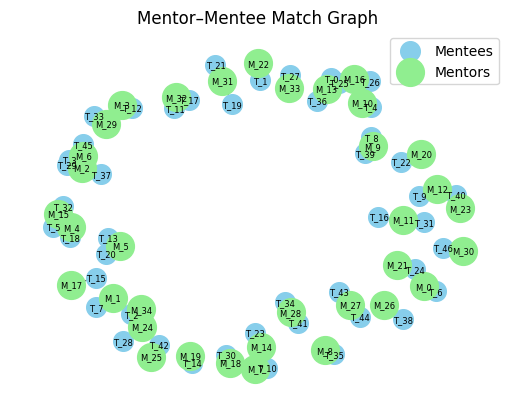

In [36]:
# bipartite graph: prefix T_ for mentees, M_ for mentors
G = nx.Graph()

for i in range(len(df_mtees)):
    G.add_node(f"T_{i}", bipartite=0)

for _, row in matches.dropna(subset=['mentor_idx']).iterrows():
    t = f"T_{int(row['mentee_idx'])}" # mentee node
    m = f"M_{int(row['mentor_idx'])}" # mentor node
    # G.add_node(t, bipartite=0)
    G.add_node(m, bipartite=1)
    G.add_edge(t, m, weight=row['score'])

# layout and drawing
pos = nx.spring_layout(G, seed=42)

# draw mentees
t_nodes = [n for n,d in G.nodes(data=True) if n.startswith('T_')]
nx.draw_networkx_nodes(G, pos, nodelist=t_nodes, node_color='skyblue', node_size=200, label='Mentees')

# draw mentors
m_nodes = [n for n,d in G.nodes(data=True) if n.startswith('M_')]
nx.draw_networkx_nodes(G, pos, nodelist=m_nodes, node_color='lightgreen', node_size=400, label='Mentors')

# draw edges with widths by compatibility
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for u,v,d in edges], width=[d['weight']*5 for _,_,d in edges], alpha=0.6)

# labels (using IDs only)
nx.draw_networkx_labels(G, pos, font_size=6)

plt.axis('off')
plt.legend(scatterpoints=1)
plt.title('Mentor–Mentee Match Graph')
plt.savefig('Mentor–Mentee Match Graph.png')
plt.show()